# Quality control analyses for modeling

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import pickle
from multiprocessing import Pool

import modeling
import helpers
import plotting
import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science','ieee','no-latex'])

# Load data

In [2]:
with open('data.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    all_data = data_dict['data']
    meta_data = data_dict['meta_data']

# Recovery and validation

## V1-V1, Cluster 0, backward meta-learning model, Blocks 1-6

### Parameter recovery

In [3]:
this_model = 'abstraction_model'
structure = 'backward'
meta_learning = True
cluster = 0
condition = 'All'
best_params_all_backward = np.load('fitting_results/backward_params.npy')
fitted_params = best_params_all_backward[(meta_data['Cluster']==cluster) & (meta_data['Condition']=='V1-V1')]
num_subject = fitted_params.shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 20]
beta_meta_bounds = [1e-6, 1]
beta_policies_bounds = [1e-6, 10]
concentration_bounds = [-2, 0.7]
v_repeat_bounds = [-10, 1]
prior_bounds = [1e-6, 1]
bounds = [alpha_bounds, beta_bounds, beta_meta_bounds, concentration_bounds, alpha_bounds, prior_bounds, prior_bounds] 
param_names = ['lr', 'beta', 'beta_meta', 'concentration', 'epsilon', 'prior_h', 'prior_w']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

all_sim_data = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, i, 1, fitted_params[i], 'V1-V1', structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data = helpers.concatenate_data(this_data, all_sim_data)
        D = helpers.get_model_fit_data(this_data, num_block=12)  
        inputs.append((this_model, D, structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save(f'fitting_results/paramrec_{structure}_{condition}_cluster{cluster}_params.npy', best_params_all)
np.save(f'fitting_results/paramrec_{structure}_{condition}_cluster{cluster}_llh.npy', best_llh_all)

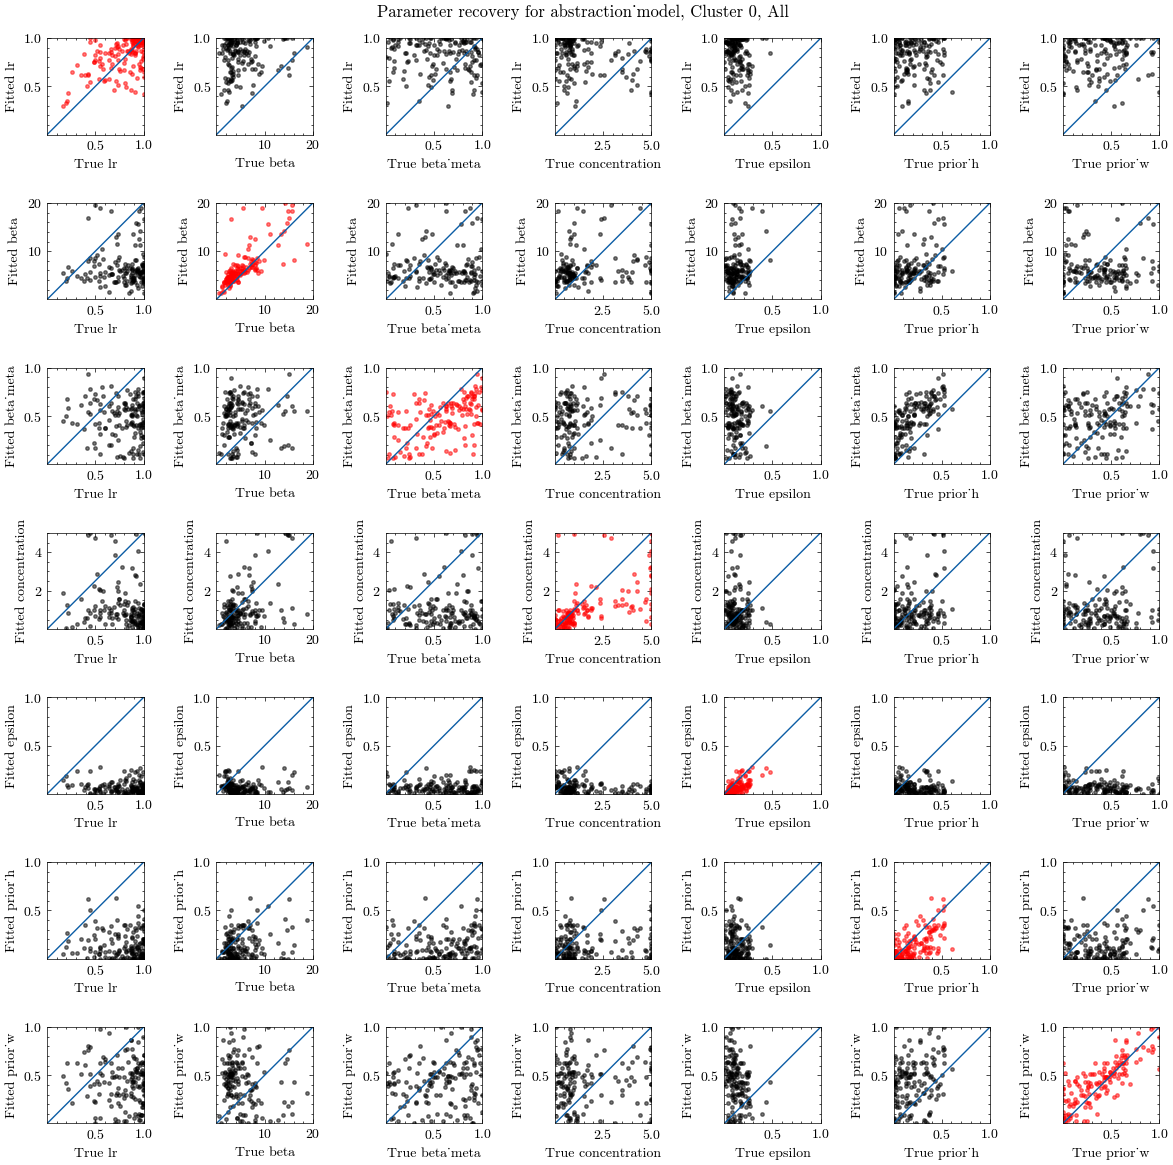

In [4]:
this_model = 'abstraction_model'
structure = 'backward'
meta_learning = True
cluster = 0
condition = 'All'
best_params_all_backward = np.load('fitting_results/backward_params.npy')
fitted_params = best_params_all_backward[(meta_data['Cluster']==cluster) & (meta_data['Condition']=='V1-V1')]
num_subject = fitted_params.shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 20]
beta_meta_bounds = [1e-6, 1]
beta_policies_bounds = [1e-6, 10]
concentration_bounds = [-2, 0.7]
v_repeat_bounds = [-10, 1]
prior_bounds = [1e-6, 1]
bounds = [alpha_bounds, beta_bounds, beta_meta_bounds, concentration_bounds, alpha_bounds, prior_bounds, prior_bounds] 
param_names = ['lr', 'beta', 'beta_meta', 'concentration', 'epsilon', 'prior_h', 'prior_w']

best_params_all = np.load(f'fitting_results/paramrec_{structure}_{condition}_cluster{cluster}_params.npy')

plt.figure(figsize=(12,12))
for p in range(len(bounds)):
    for q in range(len(bounds)):
        ax = plt.subplot(len(bounds), len(bounds), q*len(bounds)+p+1)
        p_bounds = bounds[p].copy()
        q_bounds = bounds[q].copy()

        values_p = fitted_params[:,p]
        values_q = best_params_all[:,q]
        mult, add = 1, 0
        if 'concentration' in param_names[p]: # or 'beta_meta' in param_names[p]:
            p_bounds[0] = 10**p_bounds[0] * mult + add
            p_bounds[1] = 10**p_bounds[1] * mult + add
            values_p = 10**values_p * mult + add
        if 'concentration' in param_names[q]: # or 'beta_meta' in param_names[q]:
            q_bounds[0] = 10**q_bounds[0] * mult + add
            q_bounds[1] = 10**q_bounds[1] * mult + add
            values_q = 10**values_q * mult + add
        # if 'beta_meta' in param_names[p]:
        #     p_bounds[1] = 1
        # if 'beta_meta' in param_names[q]:
        #     q_bounds[1] = 1
        color = 'r' if p == q else 'k'
        plt.plot(values_p, values_q, '.', color=color, markersize=5, alpha=0.5)
        plt.plot([p_bounds[0],p_bounds[1]], [q_bounds[0], q_bounds[1]])
        plt.xlim(p_bounds)
        plt.ylim(q_bounds)
        plt.xlabel(f'True {param_names[p]}')
        plt.ylabel(f'Fitted {param_names[q]}')
        ax.set_box_aspect(1)

plt.suptitle(f'Parameter recovery for {this_model}, Cluster {cluster}, {condition}')
plt.tight_layout()
plt.savefig(f'plots/paramrec_{structure}_{condition}_cluster{cluster}_Blocks_All.svg')
plt.show()

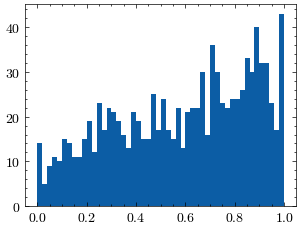

In [5]:
plt.hist(best_params_all_backward[:,2], bins=50)
plt.show()

### Validation on simulated data

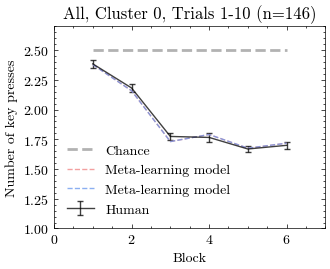

In [5]:
all_sim_data_rec = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, i, 1, fitted_params[i], 'V1-V1', structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data_rec = helpers.concatenate_data(this_data, all_sim_data_rec)
        
plotting.plot_validation_n_presses(all_sim_data, all_sim_data_rec, all_sim_data_rec, 'All', 0, nblocks=6, m1='Meta-learning', m2='Meta-learning')

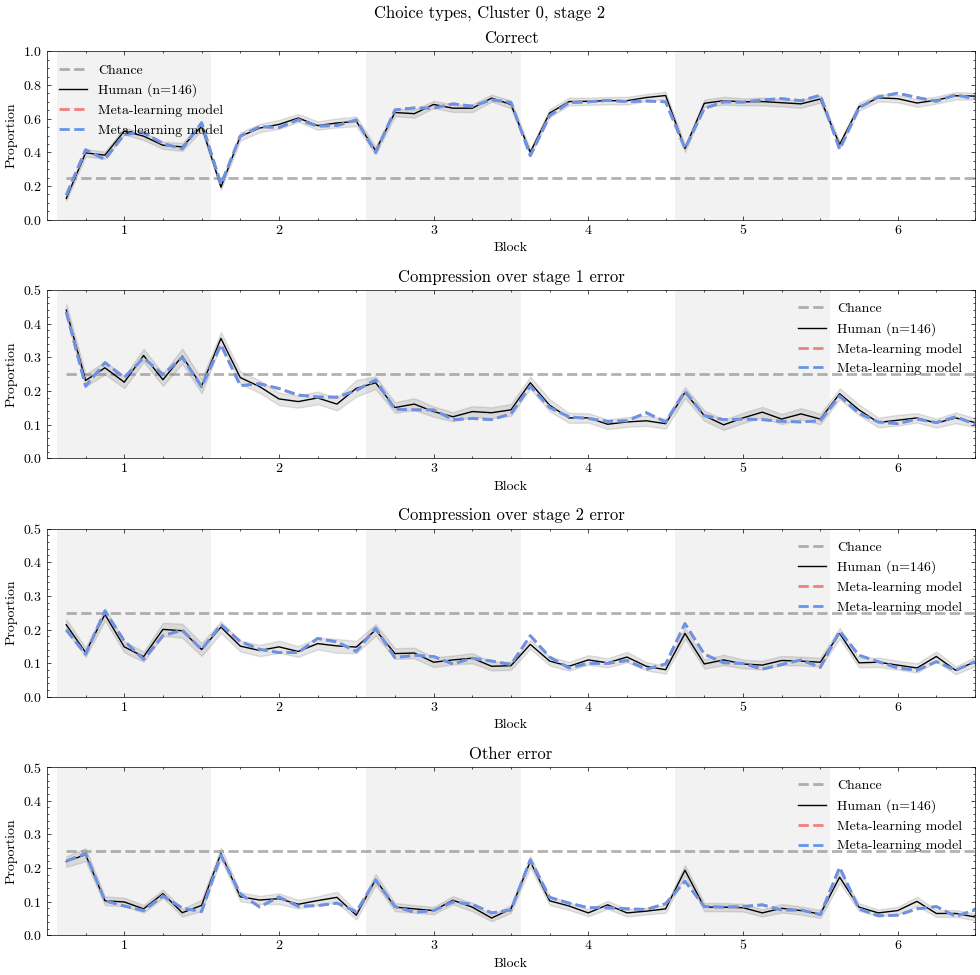

In [6]:
plotting.plot_validation_error_types(all_sim_data, all_sim_data_rec, all_sim_data_rec, 'All', cluster, nblocks=6, m1='Meta-learning', m2='Meta-learning')

## V1-V1, Cluster 0, backward no meta-learning model, Blocks 1-6

### Parameter recovery

In [8]:
this_model = 'abstraction_model'
structure = 'backward'
meta_learning = False
cluster = 0
condition = 'All'
best_params_all_backward_no_meta = np.load('fitting_results/backward_no_meta_params.npy')
fitted_params = best_params_all_backward_no_meta[(meta_data['Cluster']==cluster) & (meta_data['Condition']=='V1-V1')]
num_subject = fitted_params.shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 20]
beta_meta_bounds = [-6, 0.5]
beta_policies_bounds = [1e-6, 10]
concentration_bounds = [-2, 0.7]
v_repeat_bounds = [-10, 1]
prior_bounds = [0.01, 0.98]
bounds = [alpha_bounds, beta_bounds, beta_meta_bounds, concentration_bounds, alpha_bounds, prior_bounds] 
param_names = ['lr', 'beta', 'beta_meta', 'concentration', 'epsilon', 'prior']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

all_sim_data = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, i, 1, fitted_params[i], 'V1-V1', structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data = helpers.concatenate_data(this_data, all_sim_data)
        D = helpers.get_model_fit_data(this_data, num_block=6)  
        inputs.append((this_model, D, structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save(f'fitting_results/paramrec_{structure}_no_meta_{condition}_cluster{cluster}_params.npy', best_params_all)
np.save(f'fitting_results/paramrec_{structure}_no_meta_{condition}_cluster{cluster}_llh.npy', best_llh_all)


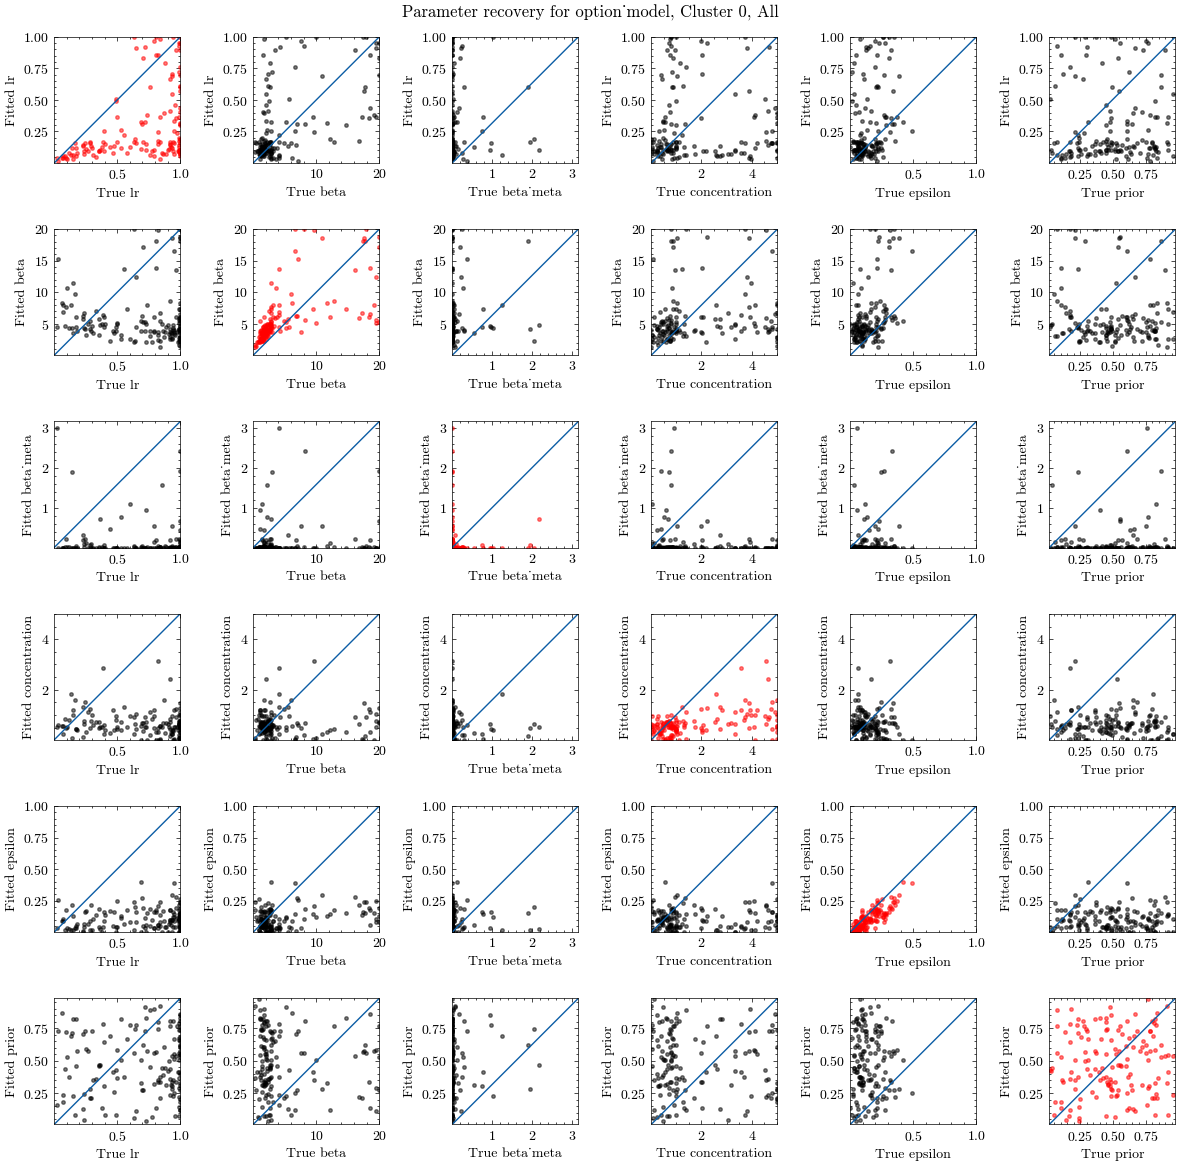

In [9]:
plt.figure(figsize=(12,12))
for p in range(len(bounds)):
    for q in range(len(bounds)):
        ax = plt.subplot(len(bounds), len(bounds), q*len(bounds)+p+1)
        p_bounds = bounds[p].copy()
        q_bounds = bounds[q].copy()

        values_p = fitted_params[:,p]
        values_q = best_params_all[:,q]
        mult, add = 1, 0
        if 'concentration' in param_names[p] or 'beta_meta' in param_names[p]:
            p_bounds[0] = 10**p_bounds[0] * mult + add
            p_bounds[1] = 10**p_bounds[1] * mult + add
            values_p = 10**values_p * mult + add
        if 'concentration' in param_names[q] or 'beta_meta' in param_names[q]:
            q_bounds[0] = 10**q_bounds[0] * mult + add
            q_bounds[1] = 10**q_bounds[1] * mult + add
            values_q = 10**values_q * mult + add
        color = 'r' if p == q else 'k'
        plt.plot(values_p, values_q, '.', color=color, markersize=5, alpha=0.5)
        plt.plot([p_bounds[0],p_bounds[1]], [q_bounds[0], q_bounds[1]])
        plt.xlim(p_bounds)
        plt.ylim(q_bounds)
        plt.xlabel(f'True {param_names[p]}')
        plt.ylabel(f'Fitted {param_names[q]}')
        ax.set_box_aspect(1)

plt.suptitle(f'Parameter recovery for {this_model}, Cluster {cluster}, {condition}')
plt.tight_layout()
plt.show()

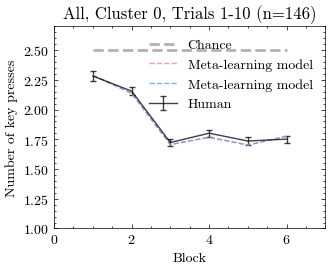

In [10]:
all_sim_data_rec = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, i, 1, fitted_params[i], 'V1-V1', structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data_rec = helpers.concatenate_data(this_data, all_sim_data_rec)
        
plotting.plot_validation_n_presses(all_sim_data, all_sim_data_rec, all_sim_data_rec, 'All', 0, nblocks=6, m1='Meta-learning', m2='Meta-learning')

### Validation on simulated data

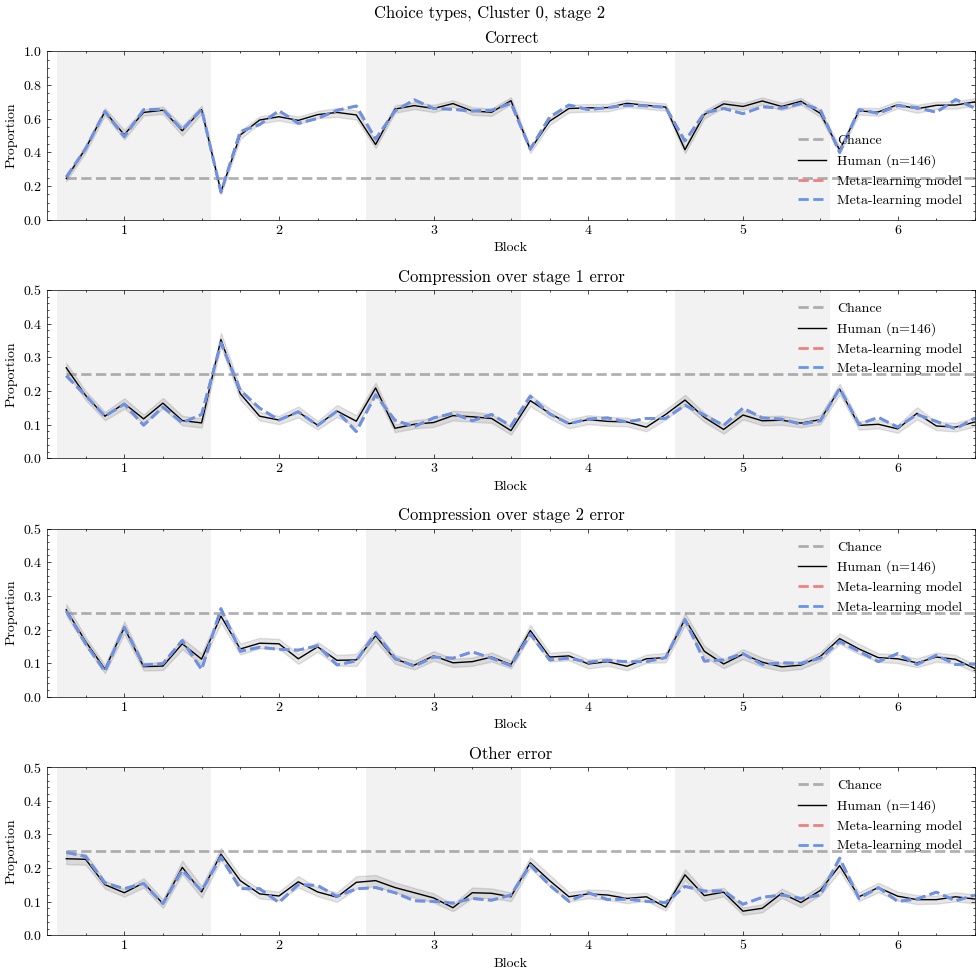

In [11]:
plotting.plot_validation_error_types(all_sim_data, all_sim_data_rec, all_sim_data_rec, 'All', cluster, nblocks=6, m1='Meta-learning', m2='Meta-learning')